# $$Morisita(A, B) = \frac{A \cdot B}{\sum{A^2} + \sum{B^2}}$$

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from dataset import get_manchester

def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)

def vvv_format(title='', ylabel='', autoscale=False, max=1):

    plt.grid()
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()

plt.rcParams['figure.figsize'] = 12, 8
    
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}
    
def per_session_plot(title, autoscale=False):
    vvv_format(title, "Morisita's Overlap Index", autoscale=autoscale)

# Quick Test 

Testing example from "Testing for Significance of Morisita's, Horn's and Related Measures of Overlap"

The morisita calculation for X and Y should be 0.83

In [2]:
x = pd.Series([.2, .3, .5])
y = pd.Series([.1, .6, .3])
morisita(x, y)

0.83333333333333326

# Load Dataset

In [3]:
unigrams, bigrams, trigrams = get_manchester("/home/paul/corpora/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

In [14]:
unigrams = unigrams[unigrams.speaker.isin(['CHI', 'MOT'])]
bigrams = bigrams[bigrams.speaker.isin(['CHI', 'MOT'])]
trigrams = trigrams[trigrams.speaker.isin(['CHI', 'MOT'])]

In [4]:
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1, drop_zeros=False):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult, drop_zeros=drop_zeros)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(m.index, m, style, label=name)
    if plot:
        per_session_plot((title or name or '') + '\n')

def plot_all_children_together(df, title):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend();
    per_session_plot(title + '\n', autoscale=True)

def plot_child_adult_morisita(df, title, drop_zeros=False):
    groups = df.groupby(['corpus', 'session']).apply(morisita_child_adult, drop_zeros=drop_zeros)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(title + '\n')
    plot_all_children_together(df, title)

<a id='basic-morisita'></a>
# Child-Adult Morisita comparison

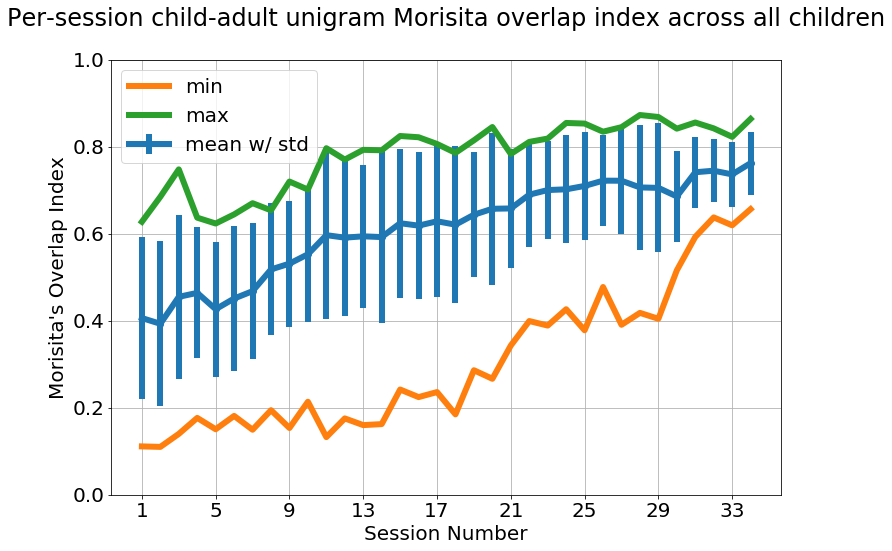

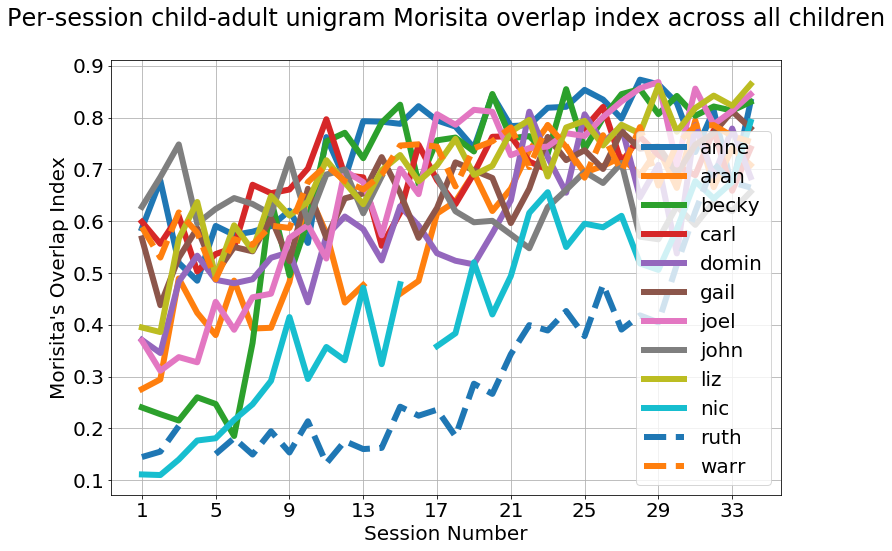

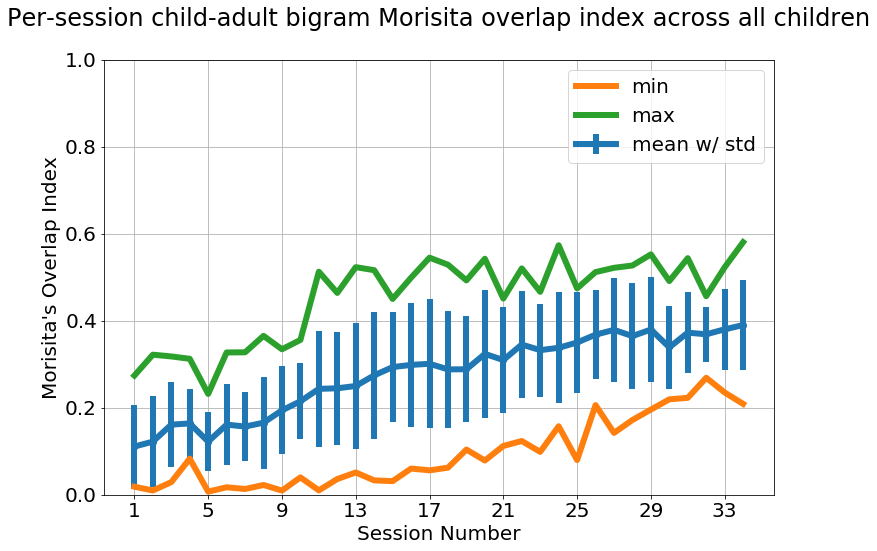

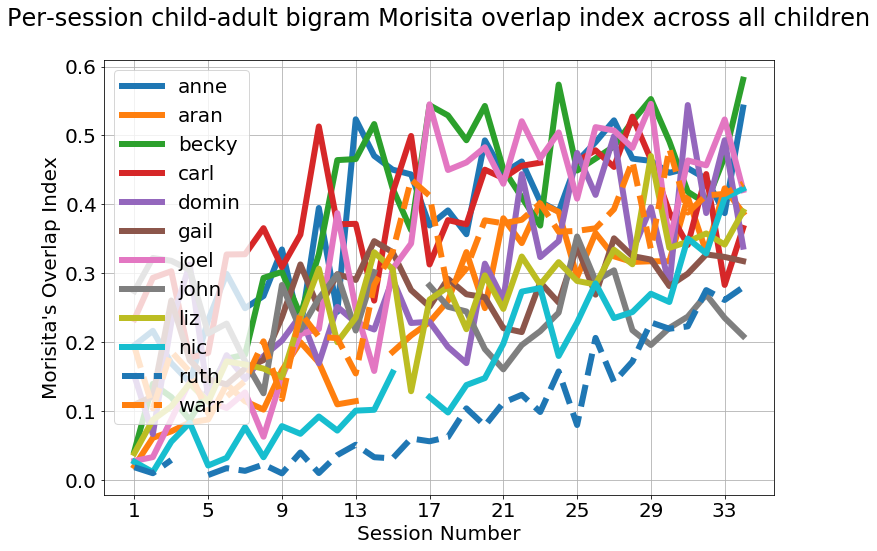

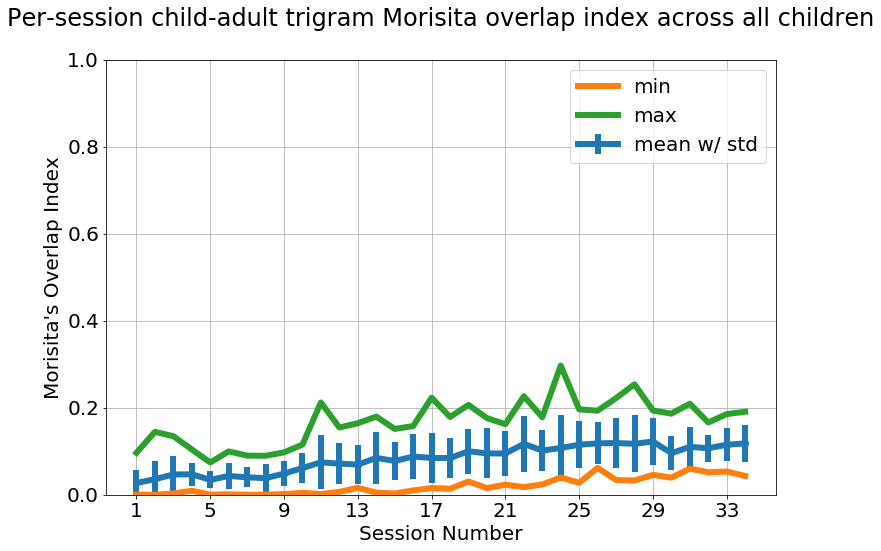

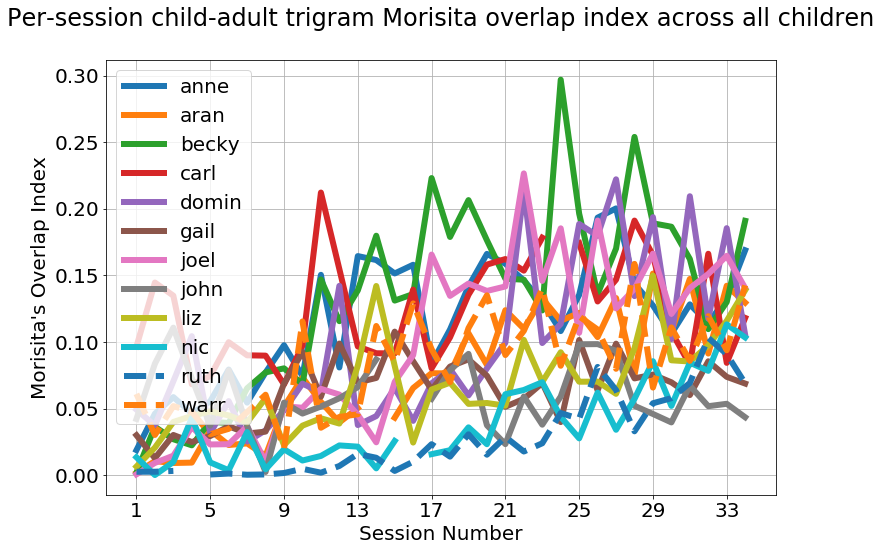

In [15]:
def child_adult_morisita_plots():
    for df, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
        plot_child_adult_morisita(
            df,
            'Per-session child-adult {} Morisita overlap index across all children'.format(name))
child_adult_morisita_plots()

<a id='zero-count-ngrams'></a>
# Child-Adult MOI - within-session common ngrams only

Ngrams, *not* vocab, so in the bigrams case, we filter to common bigrams, not common words.

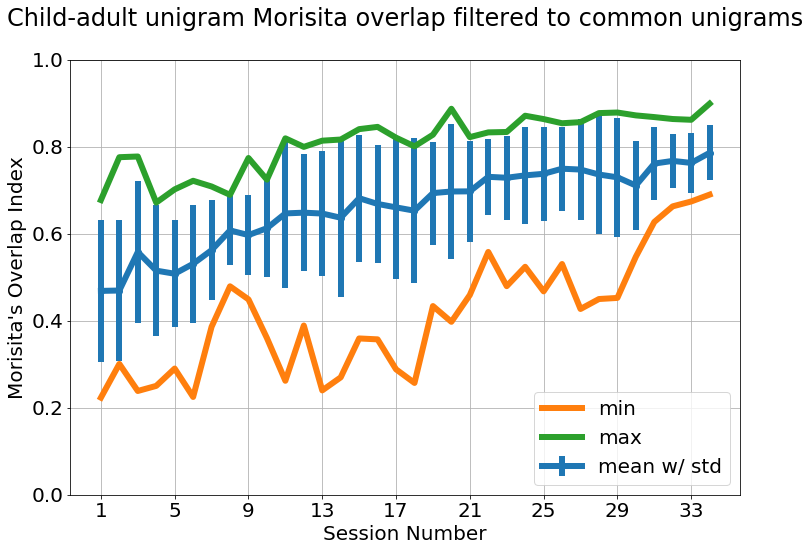

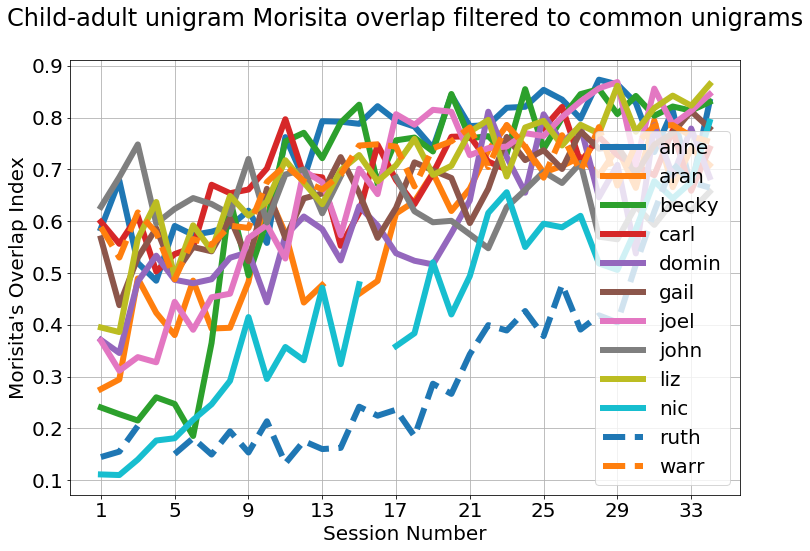

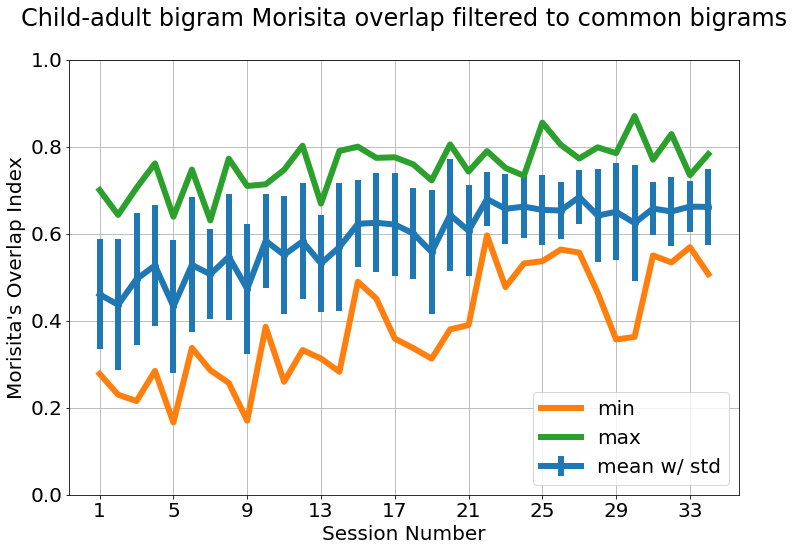

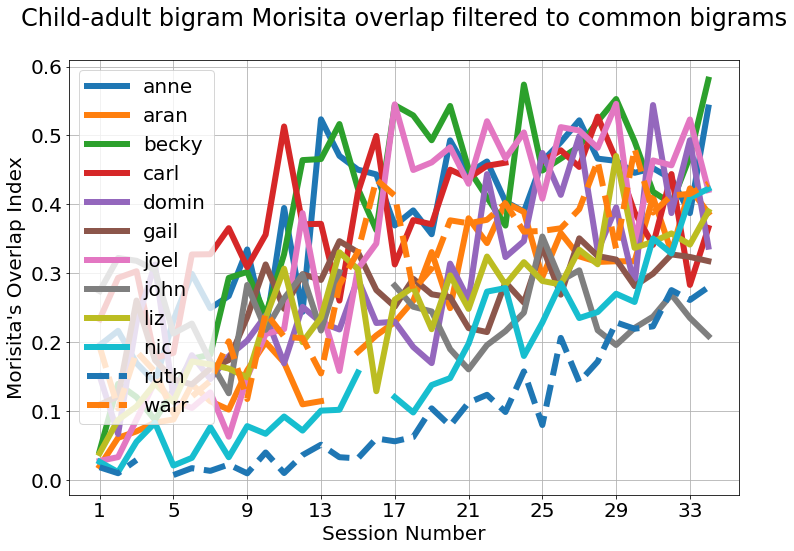

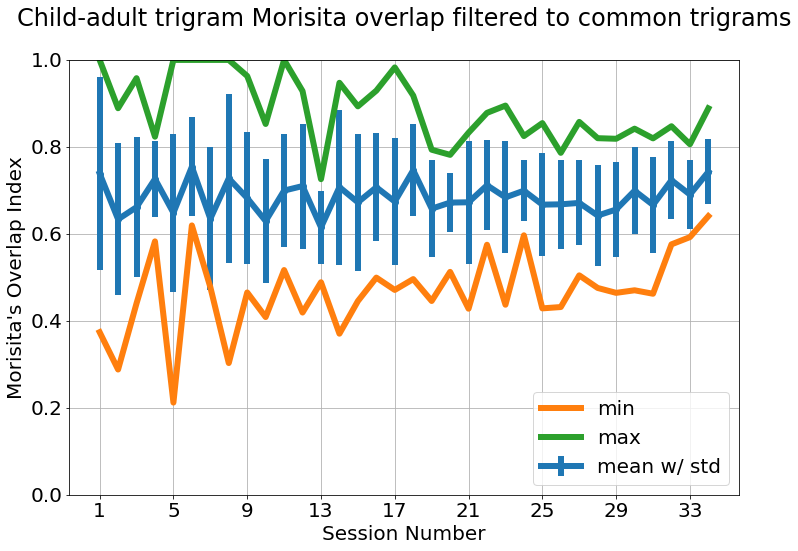

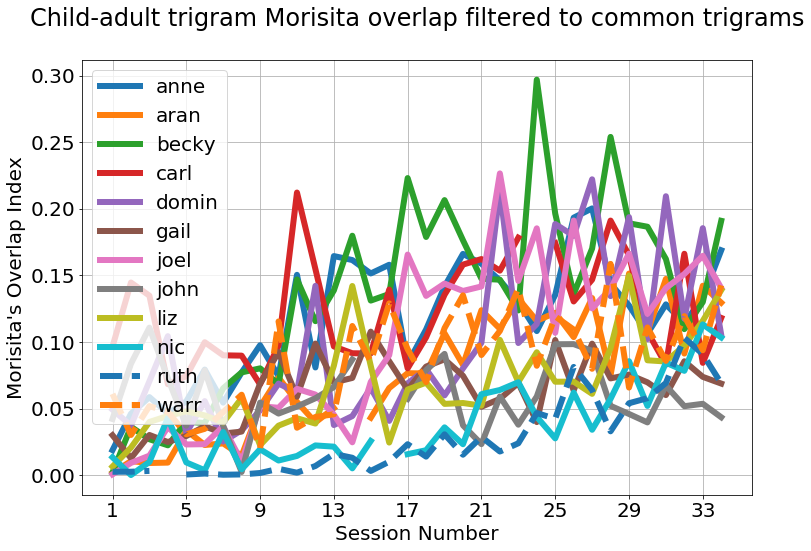

In [6]:
def common_ngram_plots():
    for df, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
        plot_child_adult_morisita(
            df,
            'Child-adult {0} Morisita overlap filtered to common {0}s'.format(name),
        drop_zeros=True)
common_ngram_plots()

<a id='zero-count-ngrams'></a>
# Child-Adult MOI - within-session common *vocab*

Here in the bigram case, for example, we filter to common words, not common bigrams.

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


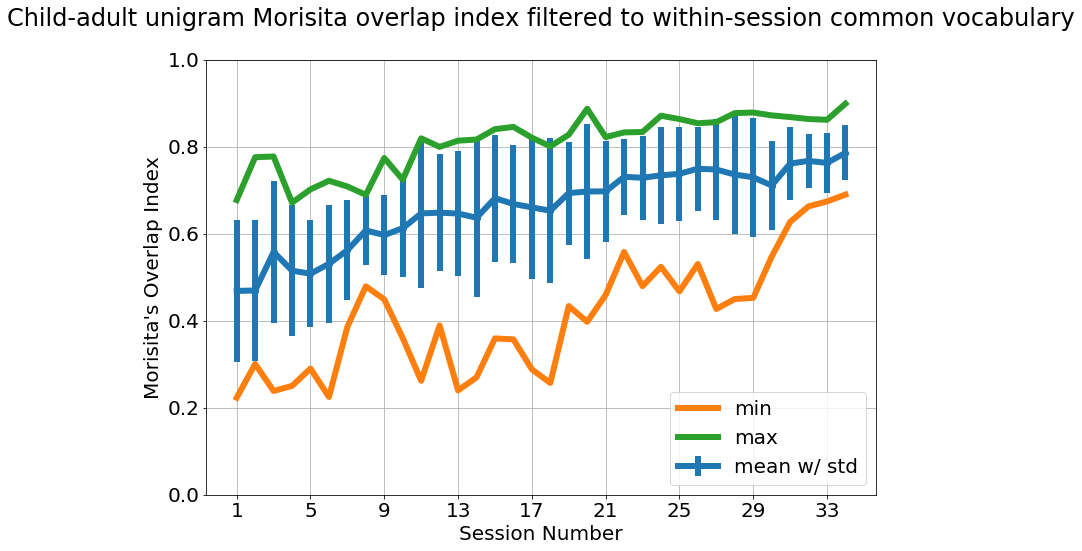

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


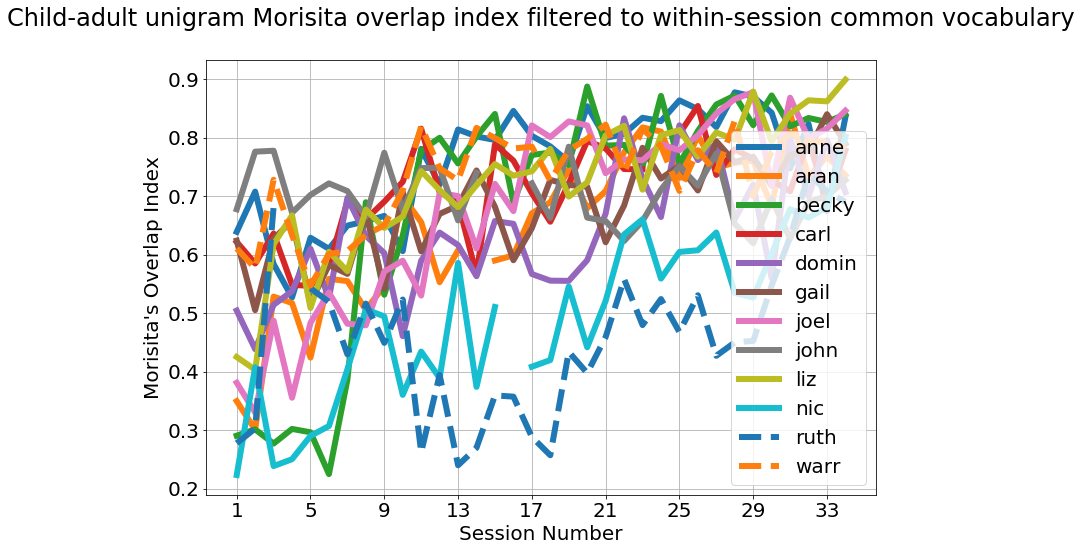

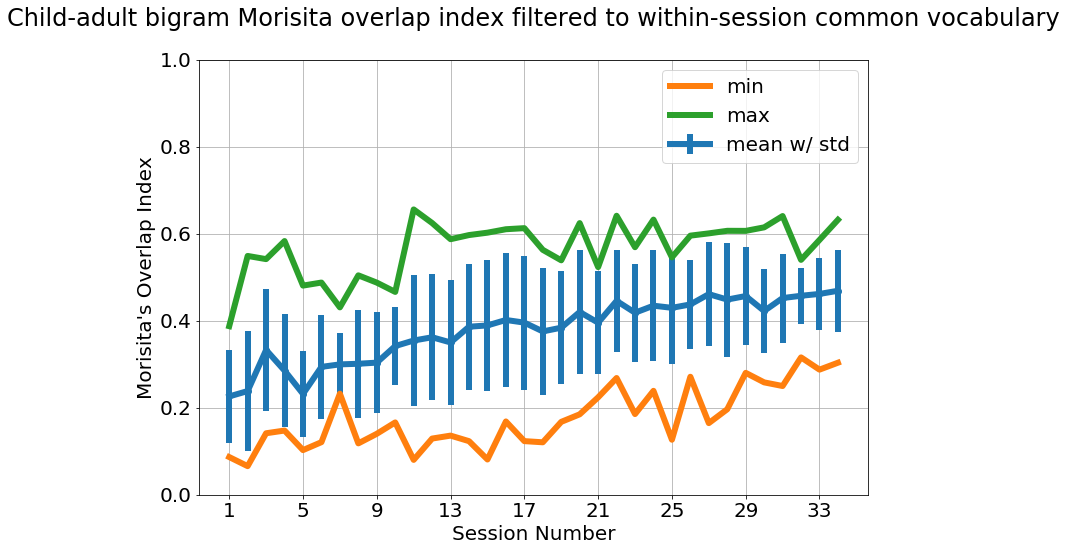

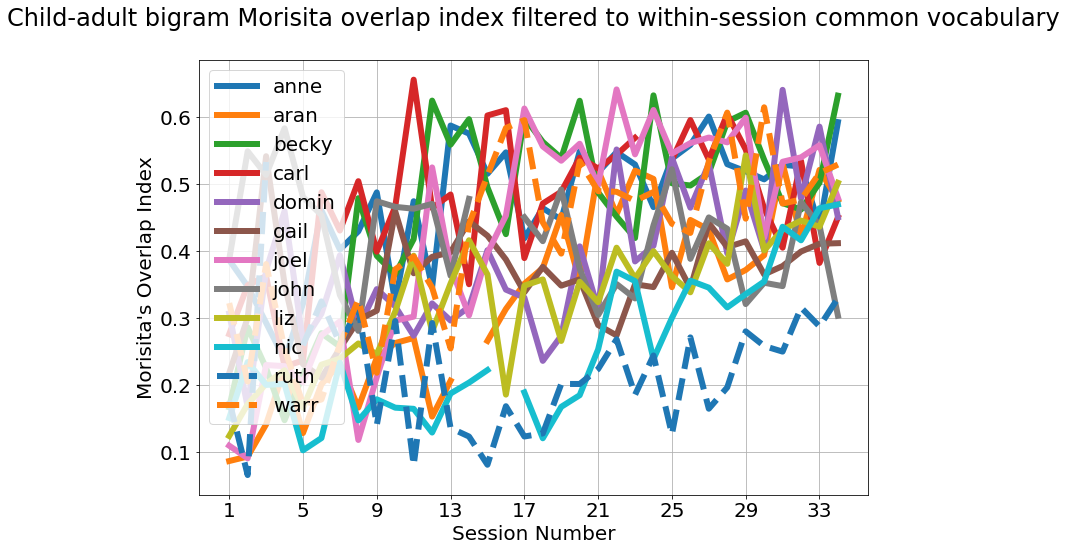

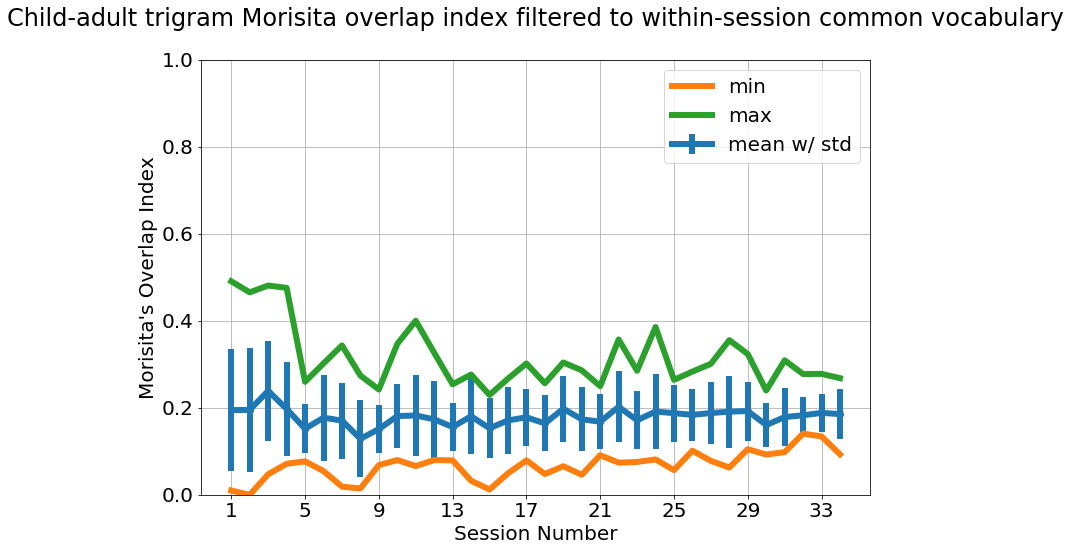

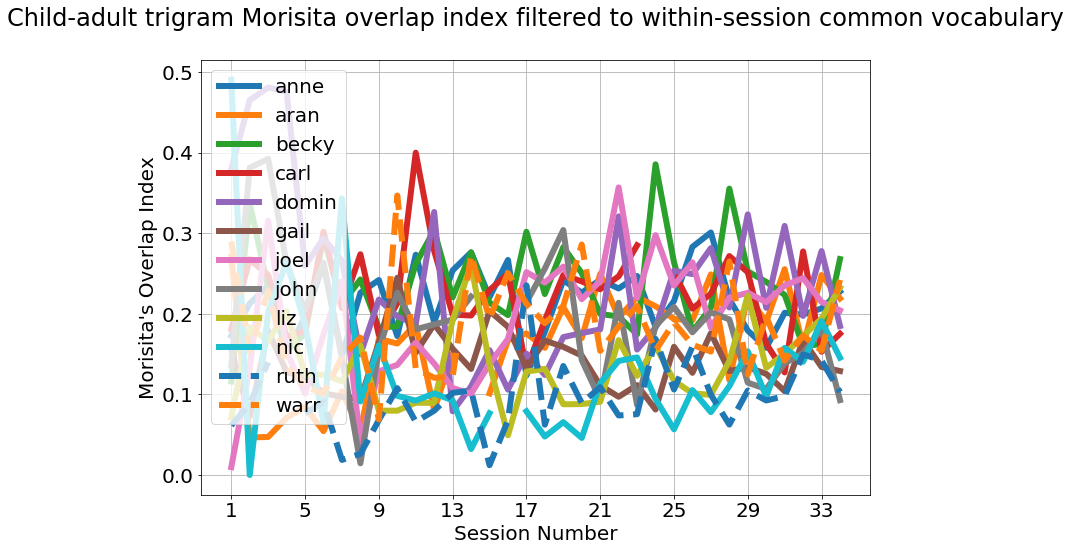

In [7]:
def valid_ngram(ngram, shared_vocab): 
    "Returns true if the string `ngrams` only contains words from the shared vocab"
    for word in ngram.split(' '):
        if word not in shared_vocab:
            return False
    return True
  
def df_to_vocab(df):
    return set(word
        for pair in df.ngram.str.split(' ')
        for word in pair)

def common_vocab(df):
    child = df[df.speaker.eq('CHI')].pipe(df_to_vocab)
    adult = df[df.speaker.eq('MOT')].pipe(df_to_vocab)
    return child & adult

def filter_to_common_vocab(df):
    vocab = common_vocab(df)
    return df[df.ngram.apply(lambda gram: valid_ngram(gram, vocab))]
    
def plot_within_session_common_vocab(df, name):
    plot_child_adult_morisita(
        
        df
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab), 
        
        ('Child-adult {0} Morisita overlap index filtered to within-session common vocabulary'
        ).format(name))
    
    
def common_vocab_plots():
    for df, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
        plot_within_session_common_vocab(df, name)

common_vocab_plots()

<a id='adult-adult-moi'></a>
# Adult-Adult Comparisons

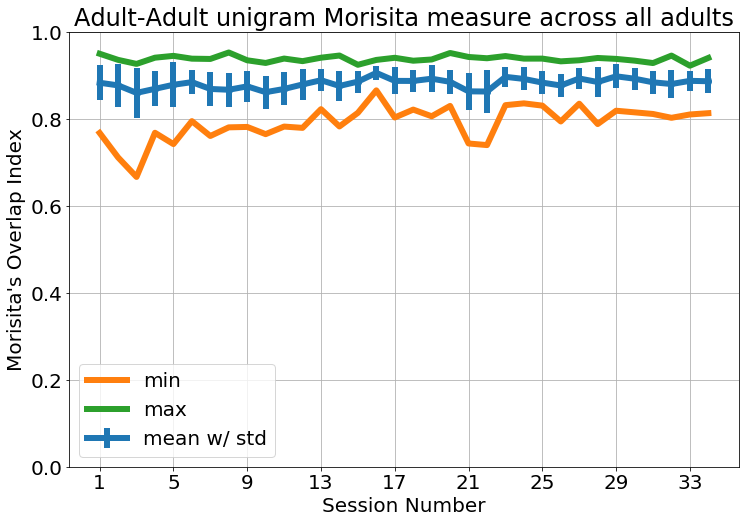

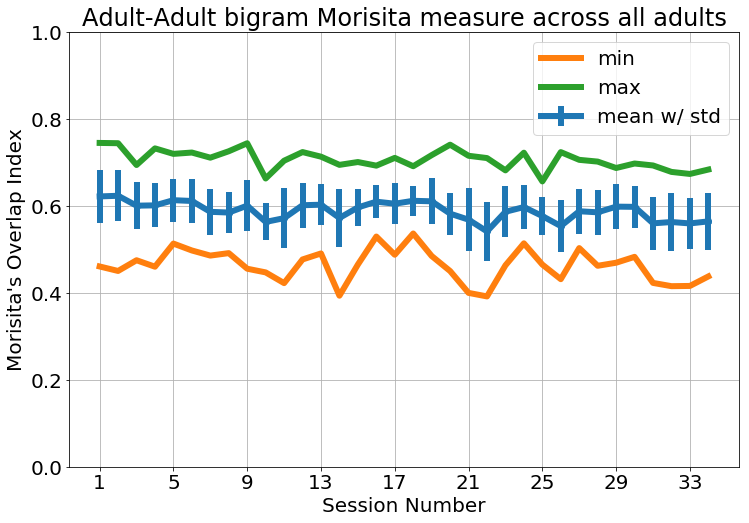

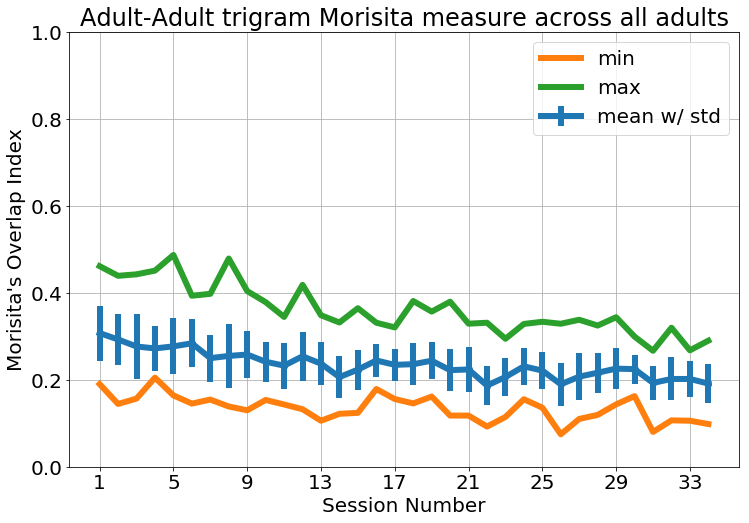

In [8]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for df, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = df[df.speaker.eq('MOT')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        df.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        df.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Adult-Adult {} Morisita measure across all adults'.format(name))

<a id='child-child-moi'></a>
# Child-Child Comparison

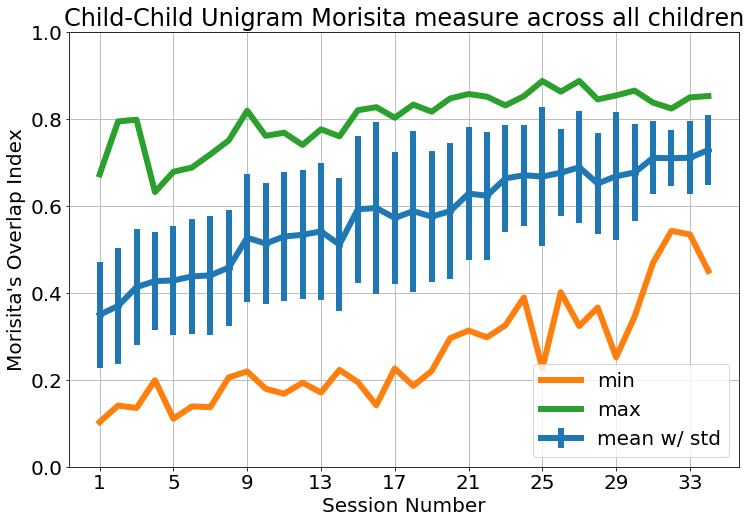

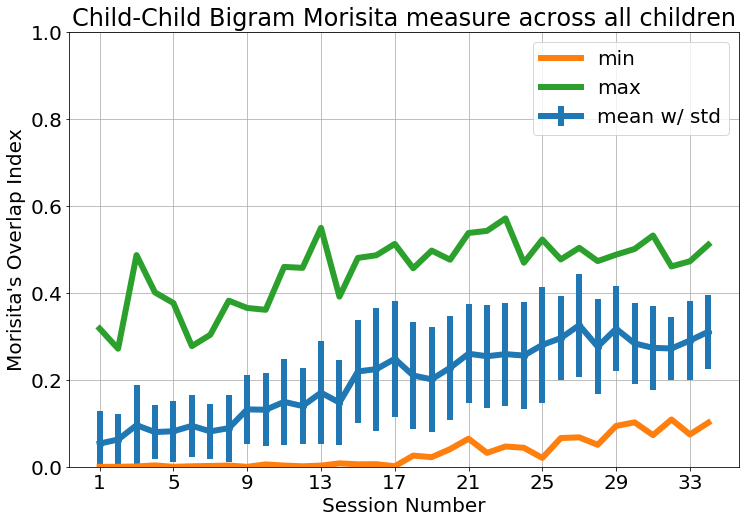

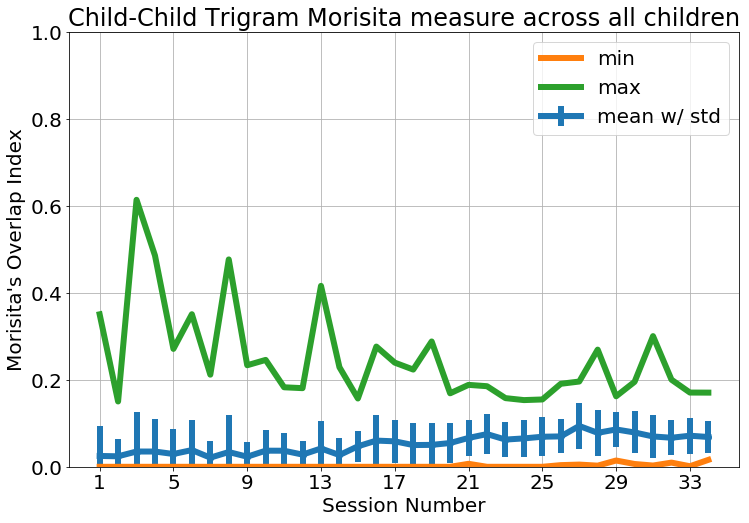

In [9]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for df, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = df[df.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        df.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        df.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Child-Child {} Morisita measure across all children'.format(name.capitalize()))

<a id='child-child-moi-common-within-session'></a>
# Child-Child Comparison filtered to common ngrams

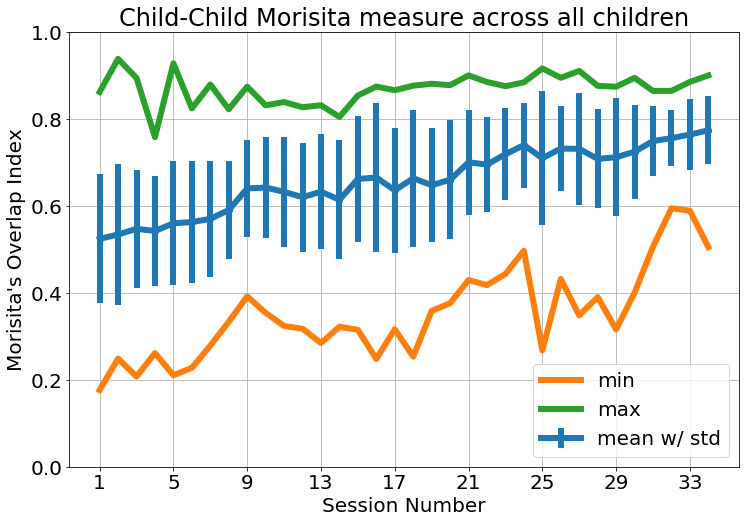

In [10]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()

groups = unigrams[unigrams.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

adult_adult = [(session1, corpus1, corpus2, morisita(
    unigrams.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
    unigrams.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts),
    drop_zeros=True))
    for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
    if (session1 == session2 and corpus1 != corpus2)]

adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
stats = (
    adult_adult_df
    .groupby('session')
    .score
    .describe()
)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats.index, stats['min'])
plt.plot(stats.index, stats['max'])
plt.ylim(0, 1)
per_session_plot('Child-Child Morisita measure across all children'.format(name))

<a id='child-child-moi-common-within-session'></a>
# Child-Child Comparison filtered to common vocab

In [ ]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()

def child_child_common_vocab_plot():

    groups = unigrams[unigrams.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        unigrams.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        unigrams.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts),
        drop_zeros=True))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Child-Child Morisita measure across all children'.format(name))

<a id='per-child-unigram'></a>
# Per-child plots of Morisita Unigrams

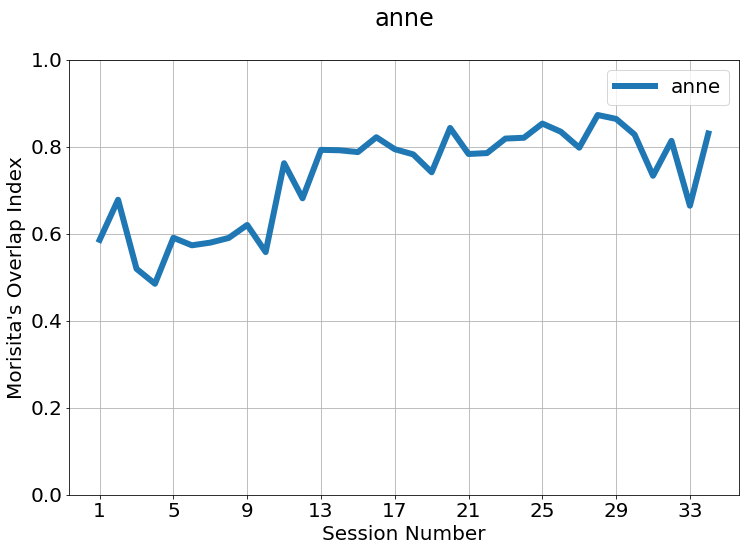

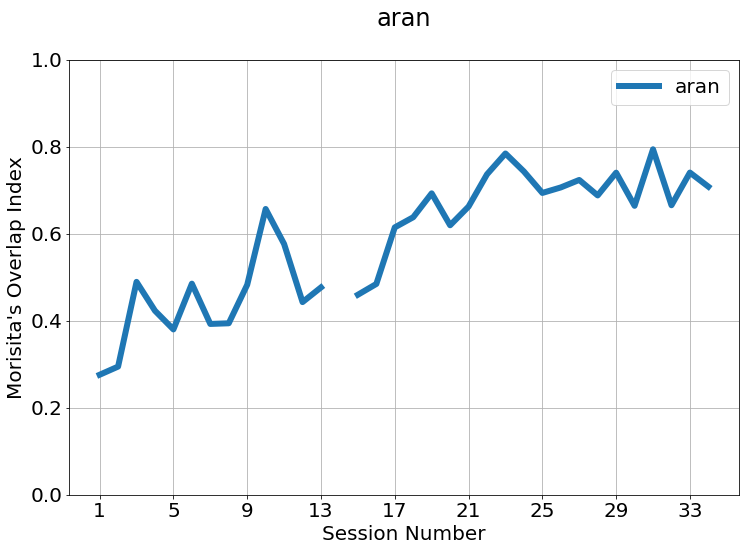

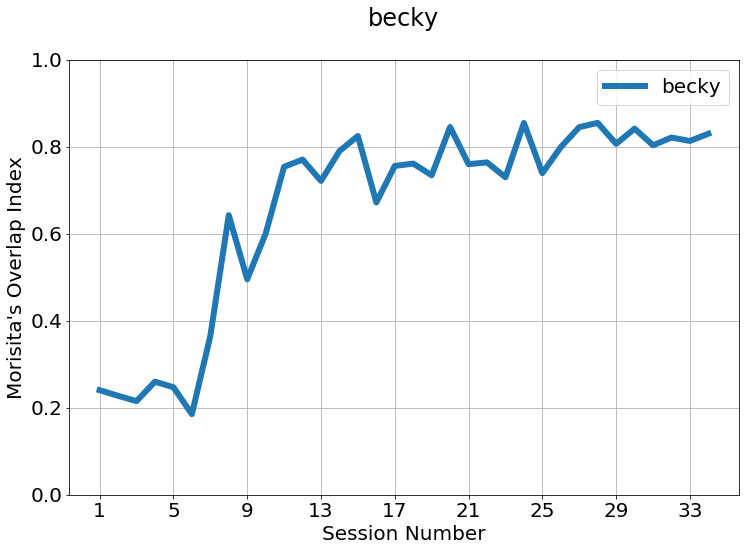

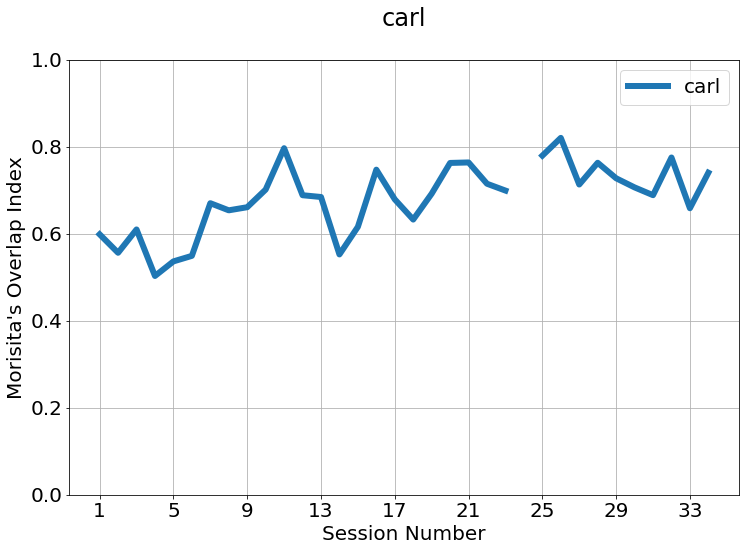

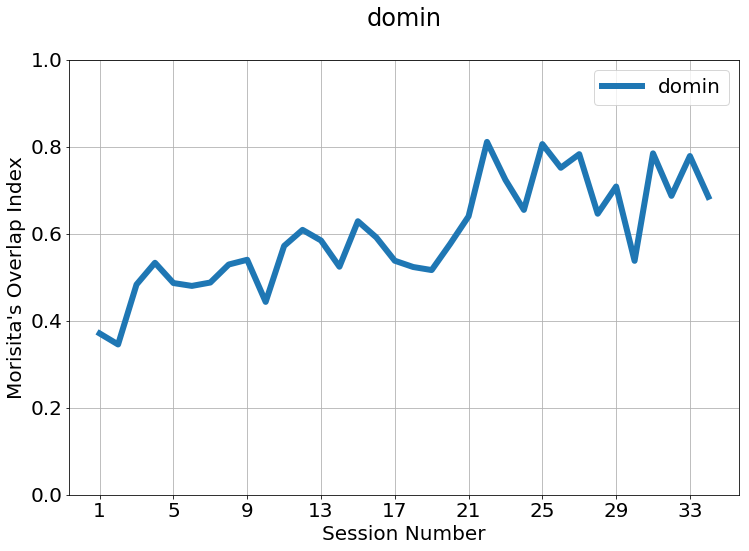

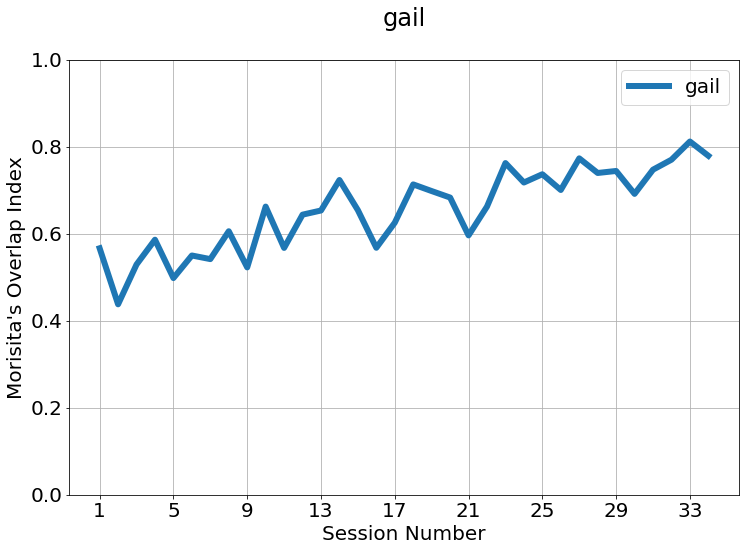

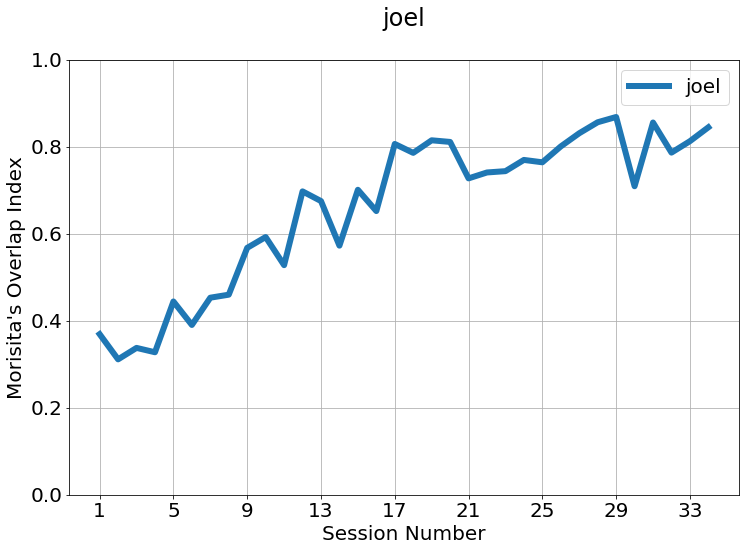

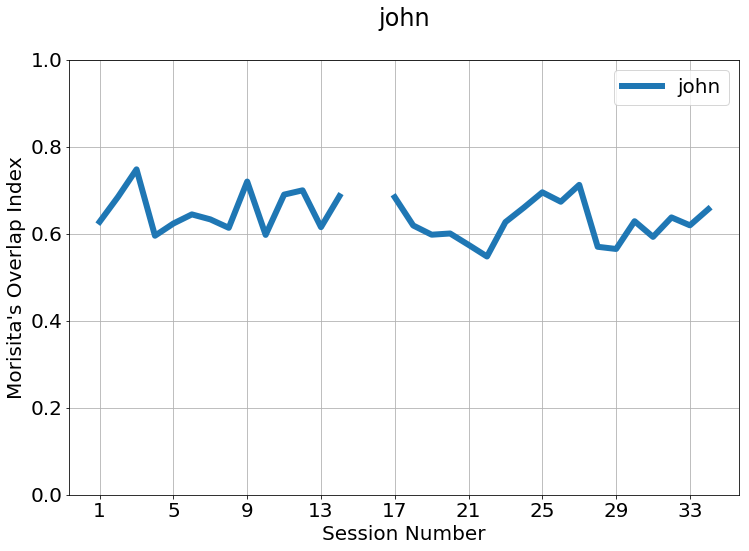

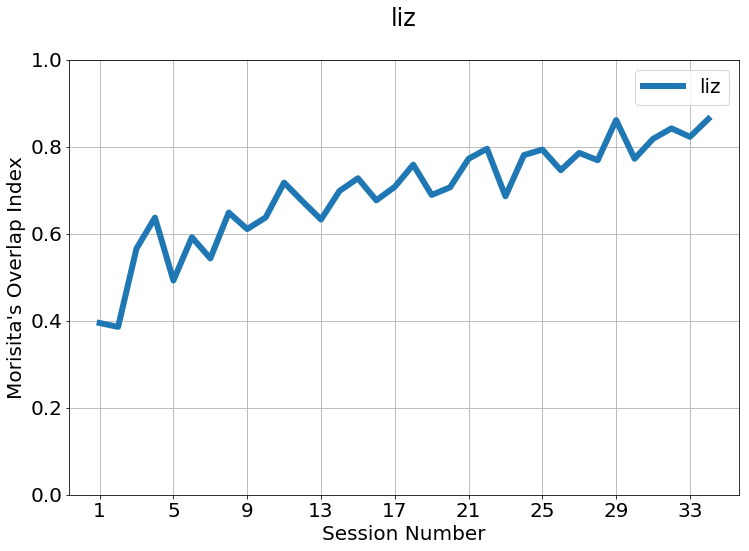

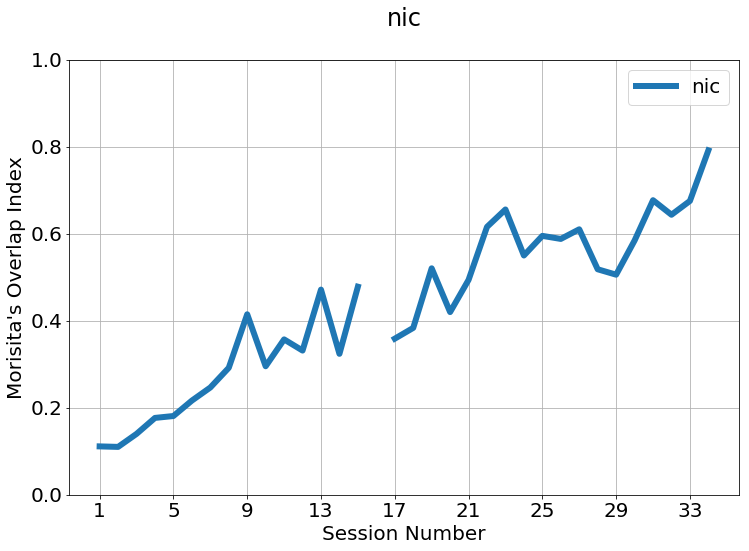

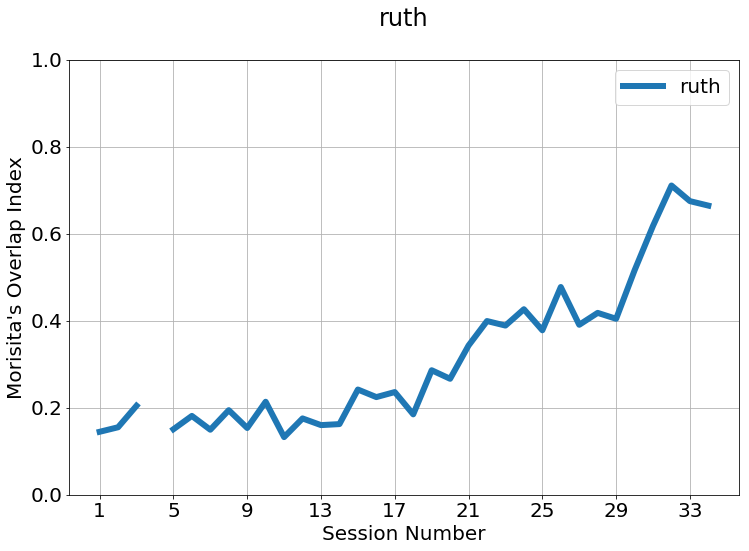

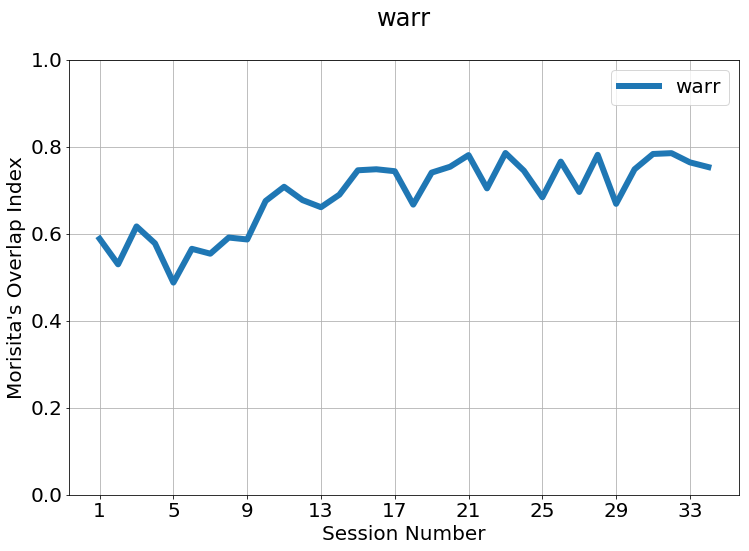

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


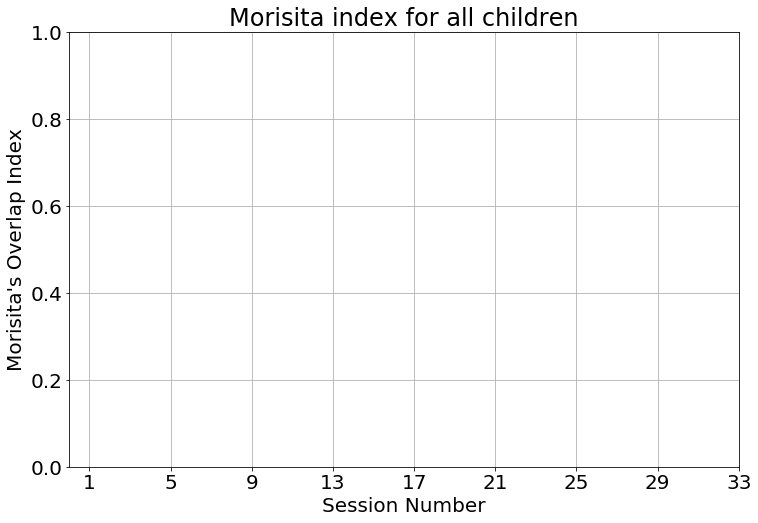

In [11]:
children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(unigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-bigram'></a>
# Per-child plots of Morisita Bigrams

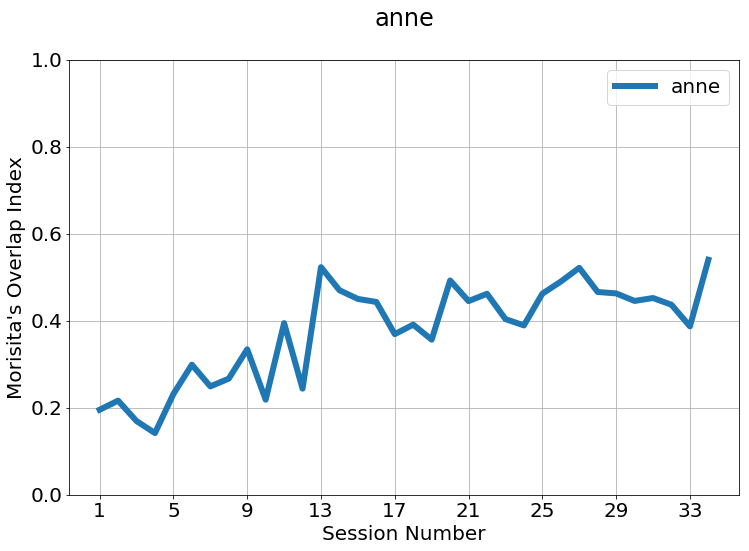

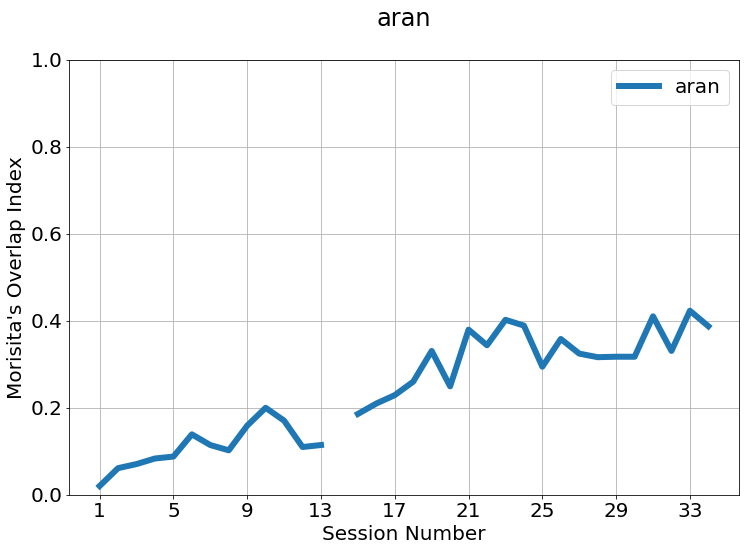

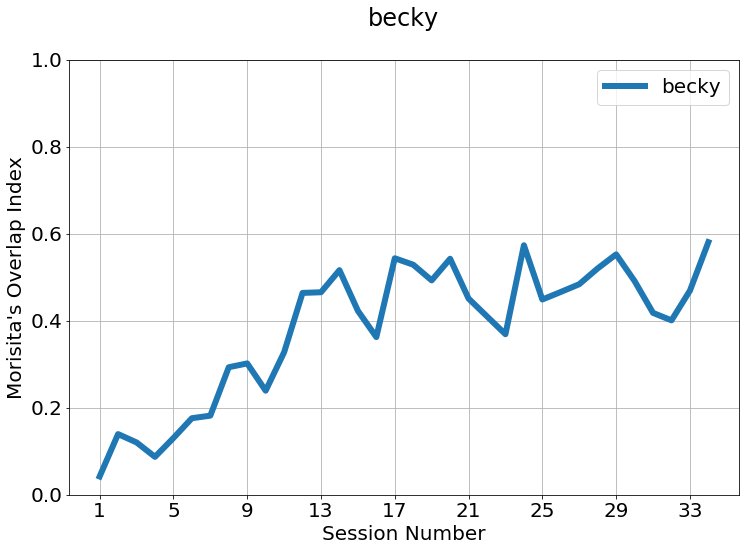

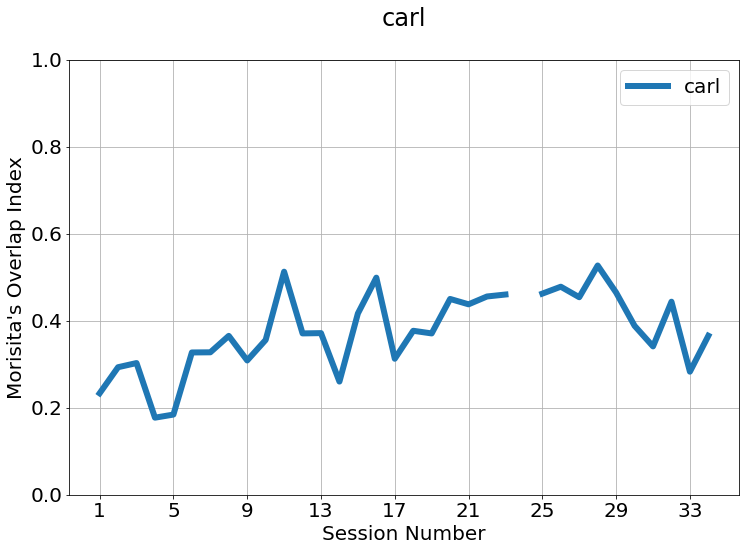

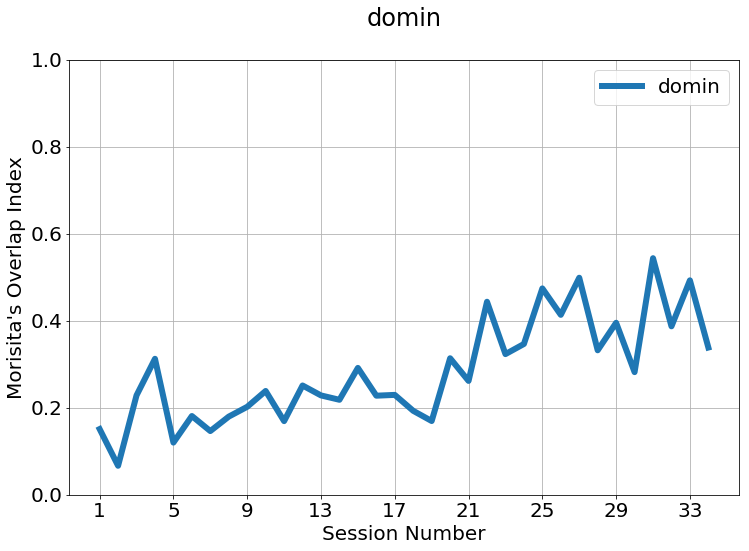

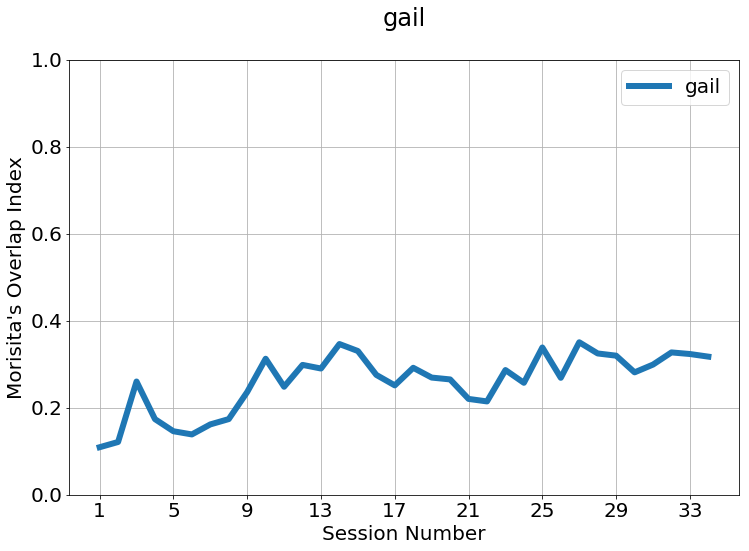

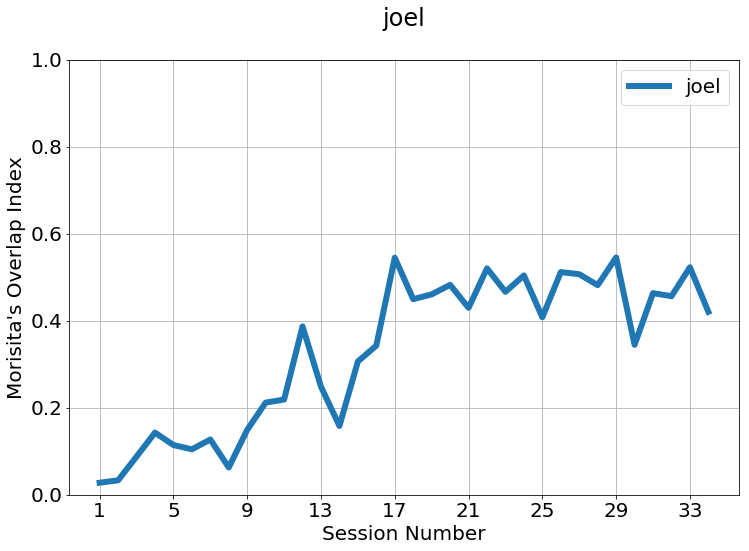

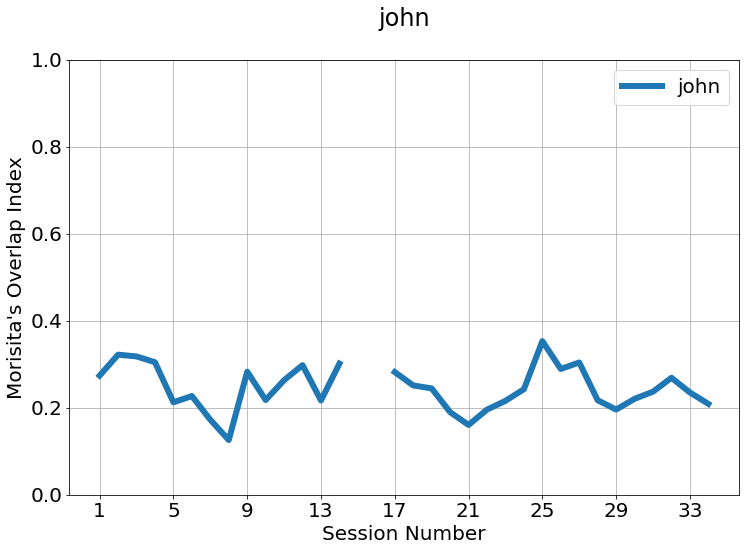

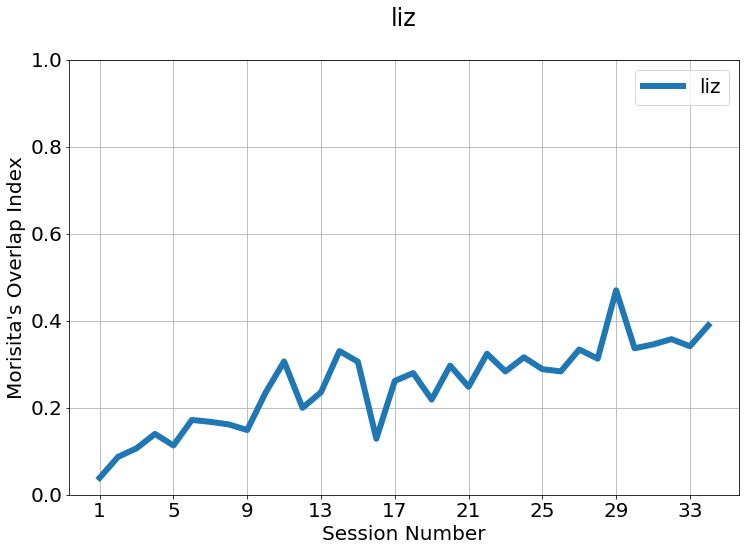

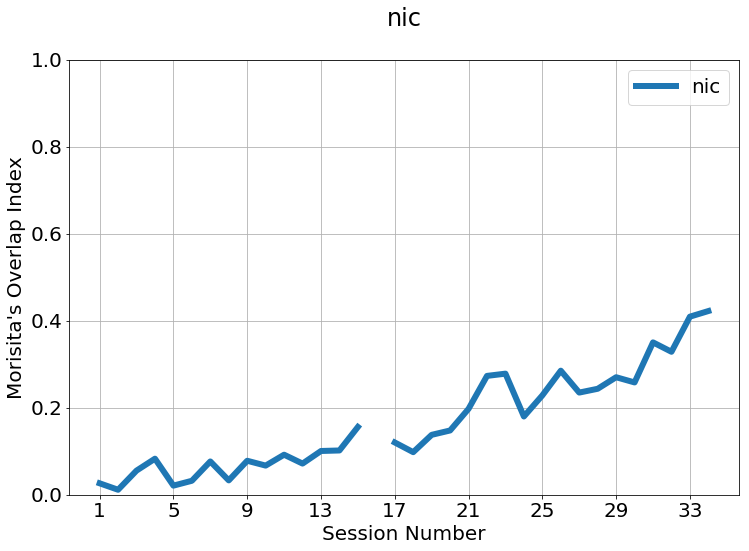

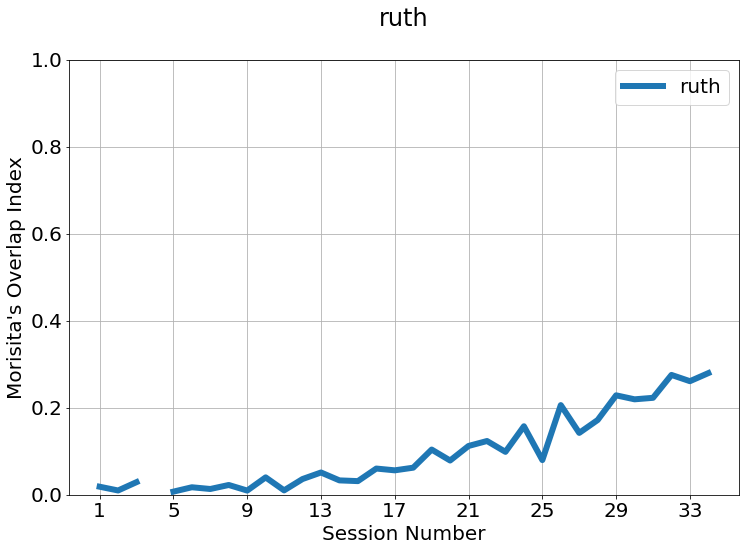

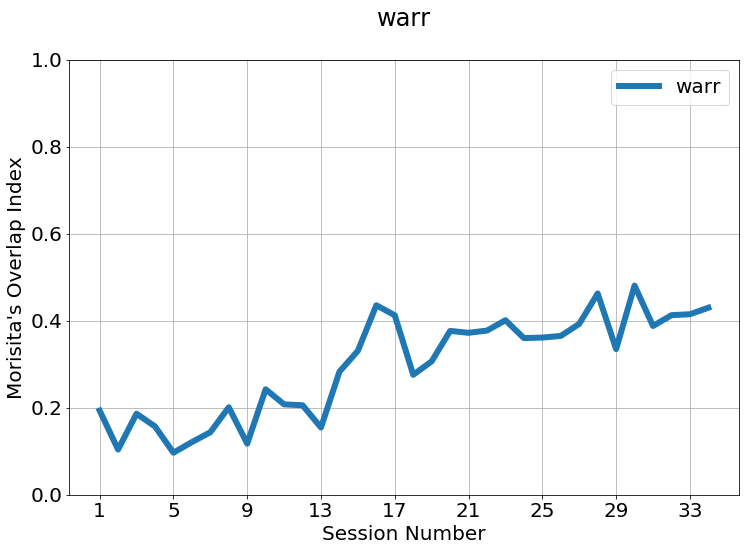

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


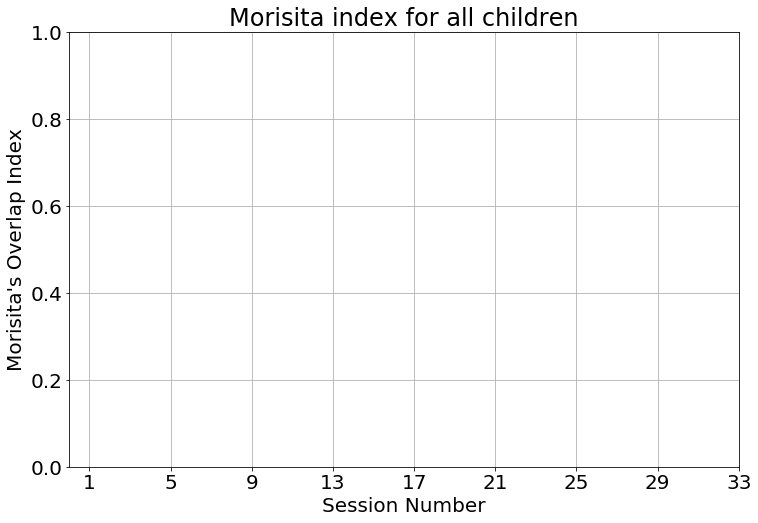

In [12]:
children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(bigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-trigram'></a>
# Per-child plots of Morisita Trigrams

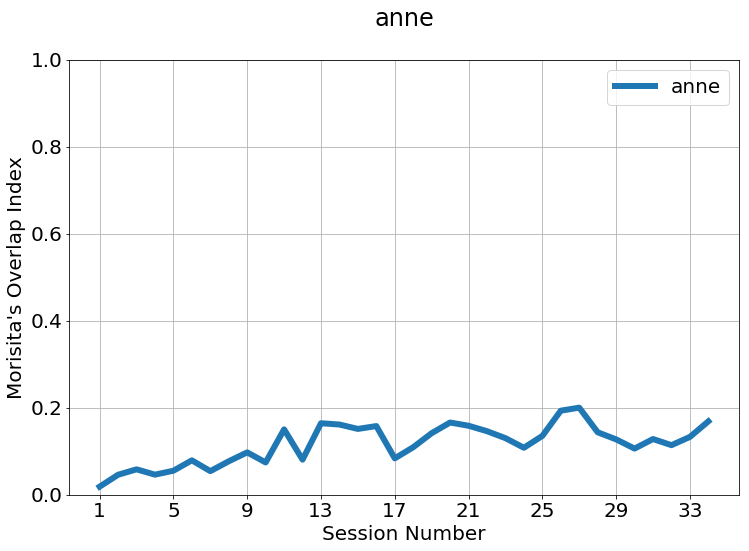

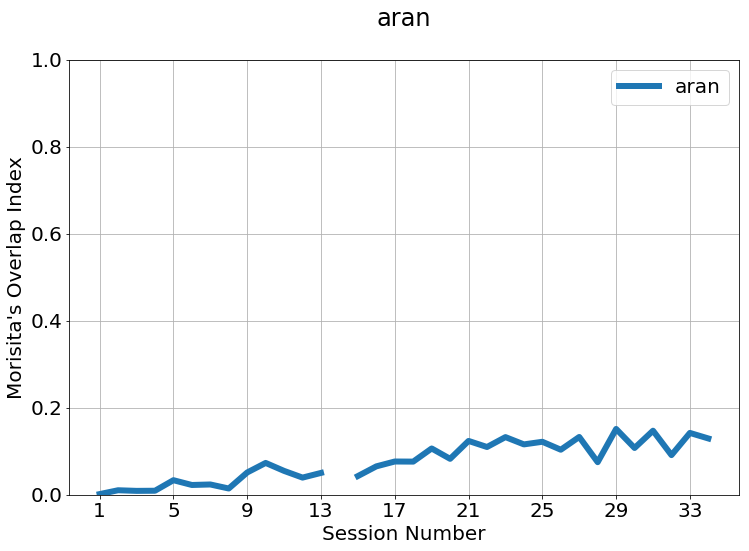

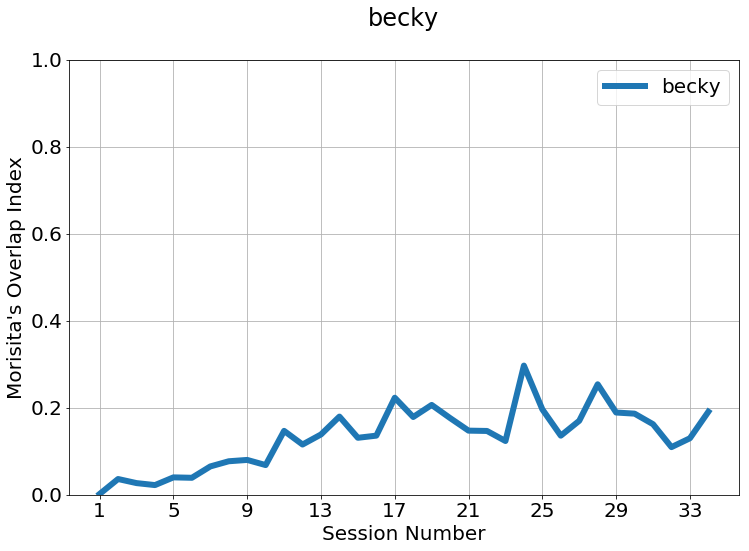

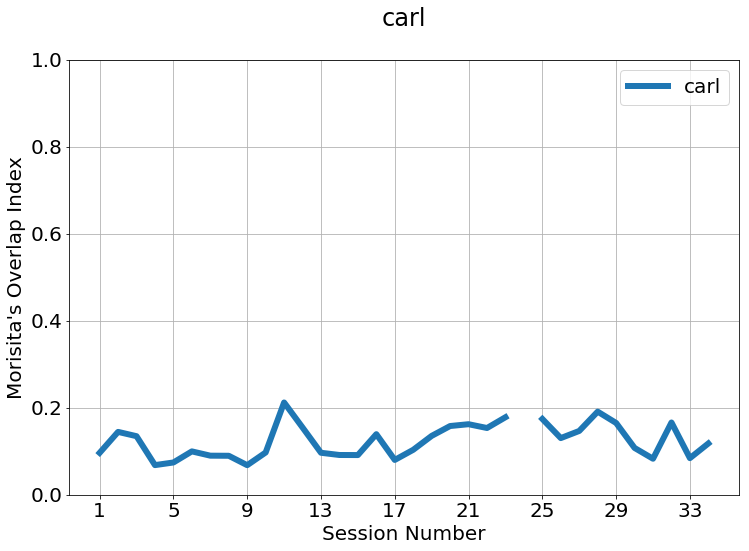

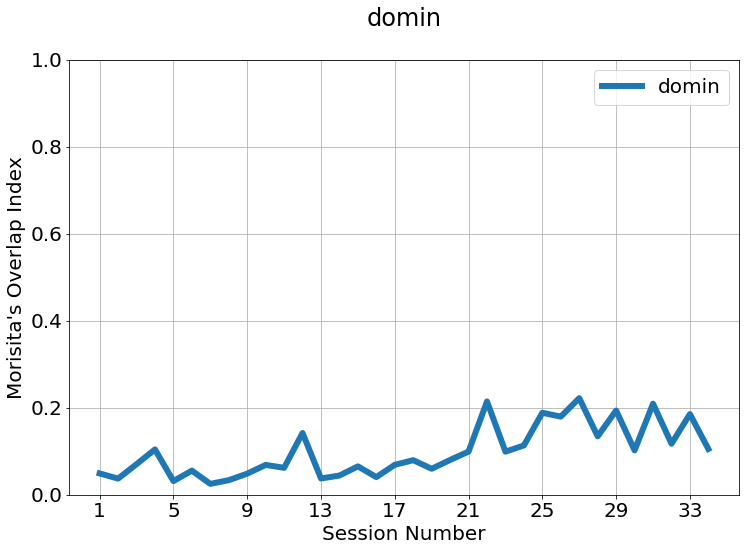

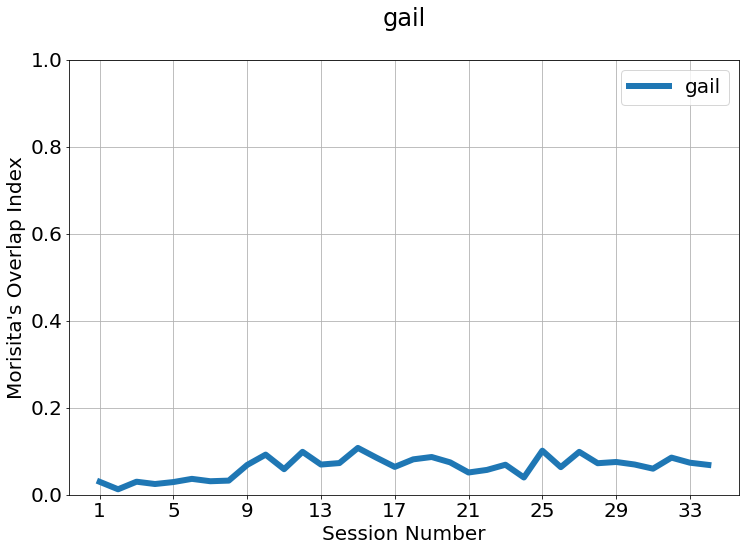

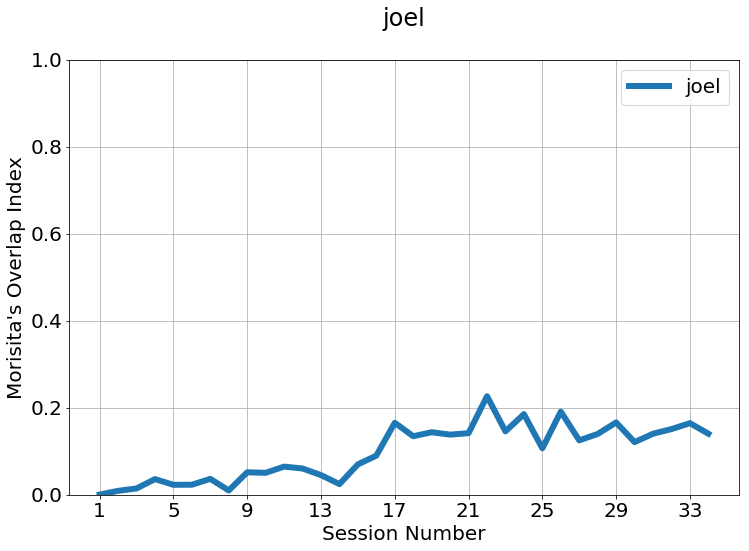

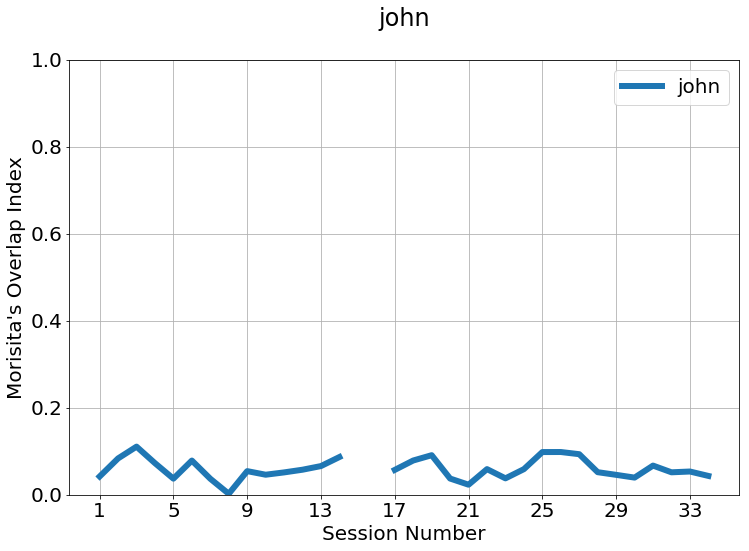

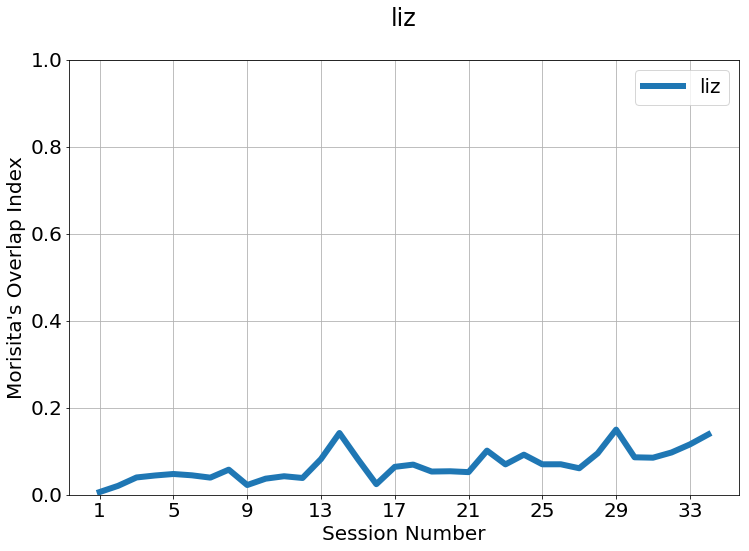

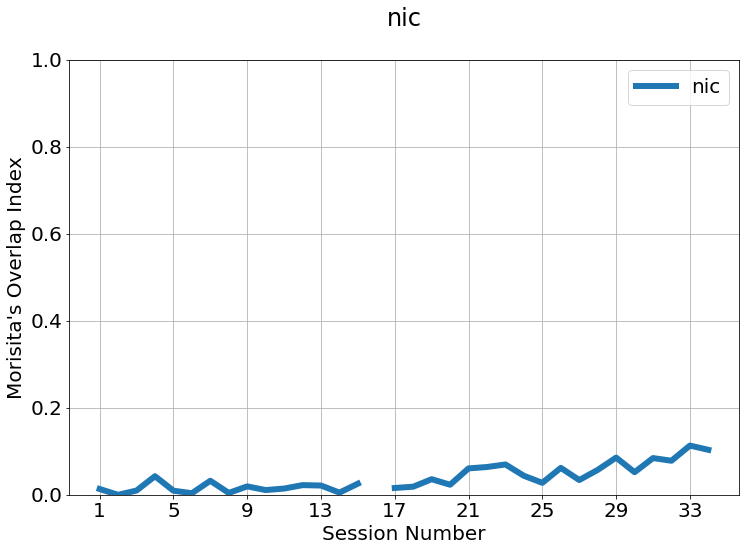

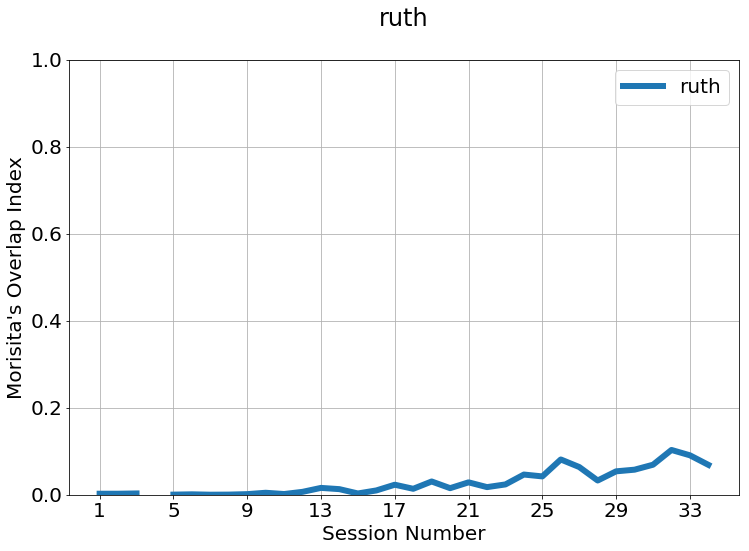

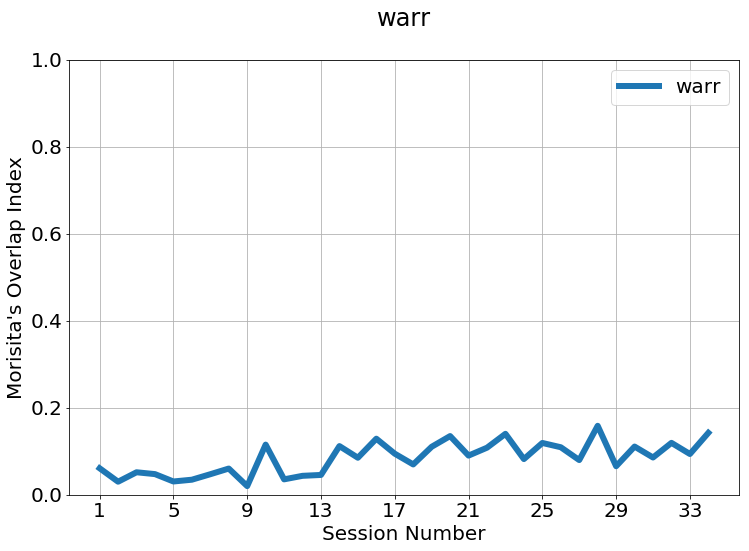

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


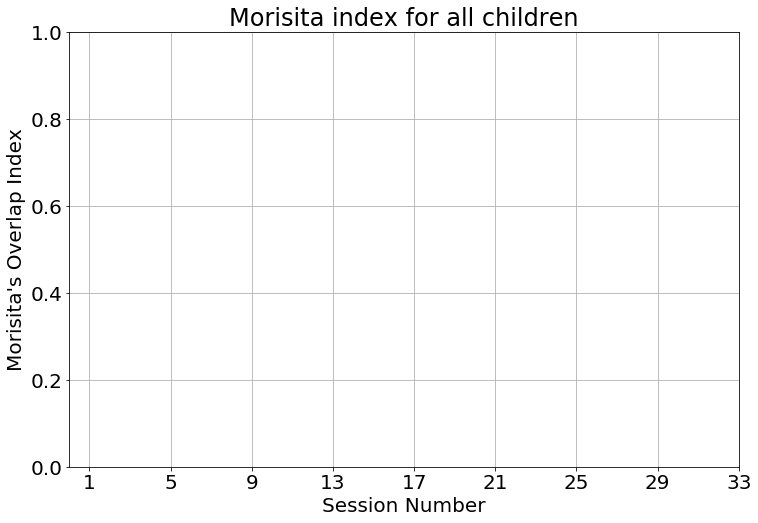

In [13]:
children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(trigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')